# Pacotes

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn import feature_extraction, model_selection, naive_bayes, metrics
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as sklm
import seaborn as sns
from sklearn.naive_bayes import ComplementNB
import numpy as np
from sklearn.metrics import confusion_matrix
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV 
import numpy as np
from prettytable import PrettyTable
import sklearn
from numpy import arange
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Funções de apoio

In [2]:
########################
###### listToString ####
########################


def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [3]:
##############################
###### Matriz de confusão ####
##############################

def matriz_confusao(y_real,y_predito,modelo):

  ### Grafico ###

  tabela=confusion_matrix(y_real,y_predito)

  group_names = ["True Neg","False Pos","False Neg","True Pos"]
  group_counts = ["{0:0.0f}".format(value) for value in
                tabela.flatten()]
  group_percentages = ["{0:.5%}".format(value) for value in
                     tabela.flatten()/np.sum(tabela)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  f = plt.figure()
  f.set_figwidth(8)
  f.set_figheight(8)

  sns.heatmap(tabela, annot=labels, fmt="", cmap='Blues')

  ### Tabela ###
  Resultados=PrettyTable()
  Resultados.field_names=["Métrica","Resultado"]
  Resultados.title= modelo
  Resultados.align["Métrica"]="l"
  Resultados.align["Resultado"]="r"

  Resultados.add_row(["Acurácia:",round(sklearn.metrics.accuracy_score(y_real,y_predito),2)])
  Resultados.add_row(["Precisão:",round(sklearn.metrics.precision_score(y_real,y_predito),2)])
  Resultados.add_row(["Recall:",round(sklearn.metrics.recall_score(y_real,y_predito),2)])
  Resultados.add_row(["F1-Score:",round(sklearn.metrics.f1_score(y_real,y_predito),2)])

  print(Resultados)
  
  return

# Conjunto de mensagens SMS a serem classificadas como spam ou mensagens legítimas:

In [4]:
sms = pd.read_csv('https://raw.githubusercontent.com/D3B0R4H/Trabalho3/master/SMSSpamCollection', sep='\t', header=None)
sms.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
sms.columns = ['class', 'text']
sms.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Análise exploratória do dataset e tratamento

In [6]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
sms['class'].value_counts()/len(sms)

ham     0.865937
spam    0.134063
Name: class, dtype: float64

In [8]:
sms['class'].value_counts()

ham     4825
spam     747
Name: class, dtype: int64

Temos mais mensagens genuínas do que de spam no dataset, o que pode gerar problemas no momento de treinar o modelo.

In [9]:
Counter(' '.join(sms['text']).lower().split()).most_common(50)

[('to', 2237),
 ('i', 2217),
 ('you', 1921),
 ('a', 1433),
 ('the', 1329),
 ('u', 998),
 ('and', 968),
 ('is', 869),
 ('in', 859),
 ('my', 755),
 ('for', 704),
 ('your', 677),
 ('of', 614),
 ('me', 611),
 ('have', 571),
 ('call', 559),
 ('on', 521),
 ('are', 487),
 ('that', 470),
 ('it', 466),
 ('2', 457),
 ('so', 423),
 ('but', 422),
 ('or', 415),
 ('not', 411),
 ('at', 400),
 ('can', 386),
 ('ur', 385),
 ('if', 382),
 ('with', 379),
 ('will', 379),
 ("i'm", 377),
 ('be', 376),
 ('get', 375),
 ('just', 365),
 ('do', 364),
 ('we', 346),
 ('this', 312),
 ('when', 283),
 ('from', 277),
 ('&lt;#&gt;', 276),
 ('go', 265),
 ('up', 264),
 ('all', 261),
 ('no', 258),
 ('4', 255),
 ('how', 254),
 ('what', 252),
 ('now', 247),
 ('.', 241)]

É possível notar que as principais palavras são stopwords. Para uma melhor análise, precisamos retirá-las, pois elas não serão importantes na classificação.

%% Falar o que é stopword

In [10]:
feat_ext = feature_extraction.text.CountVectorizer(stop_words = 'english', encoding='ansi')
feat_ext.get_stop_words()
stop_words = feat_ext.get_stop_words()

In [11]:
sms_1 = ' '.join(sms['text']).lower().split()
sms_limpo = [word for word in sms_1 if word not in stop_words]

In [12]:
Counter(sms_limpo).most_common(10)

[('u', 998),
 ('2', 457),
 ('ur', 385),
 ("i'm", 377),
 ('just', 365),
 ('&lt;#&gt;', 276),
 ('4', 255),
 ('.', 241),
 ('like', 236),
 ('got', 235)]

Temos como as palavras mais frequentes abreviações normalmente utilizadas em mensagens: u - you, 2 - to, ur - you are, 4 - for; Também temos I'm que deveria estar nas stopwords e pontuação. Algumas pontuações permanecem juntas das palavras, outro ponto a ser corrigido.


Palavras que indiquem que a pessoa deva clicar em algo, que demonstre urgência em resposta ou algo muito fácil pode nos ajudar e indicar se é phishing. Já palavras imperativas, motivadoras que indiquem promoções, ou nome de empresas podem indicar spam.  


Também podemos pensar que as mensagens de spam indiquem algum link ou página, o que poderia ser mais facilmente identificado se separarmos as palavras também por pontos.

In [13]:
# Carregando as Stopwords em uma lista
NLTK_stop_words_list=stopwords.words('english')
print(NLTK_stop_words_list)
print("Total numbers of stop words are ")
print(len(NLTK_stop_words_list))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
# Inserindo stopwords de um arquivo pessoal
custom_stop_word_list = ' '.join(pd.read_csv('https://raw.githubusercontent.com/D3B0R4H/Trabalho3/master/StopWords.csv', sep=";")['SW']).lower().split()

final_stopword_list = custom_stop_word_list + NLTK_stop_words_list

Stopwords atualizadas.

In [15]:
sms_1 = ' '.join(sms['text']).lower().replace('.', ' ').replace(',', ' ').replace('?', ' ? ').replace('!', ' ! ').replace('\\', ' \\ ').replace(':', ' : ').replace(';', ' ; ').replace('-', ' - ').replace('_', ' _ ').replace('@', ' @ ').replace('(', ' ').replace(')', ' ').replace('$', ' $ ').replace('£', ' £ ').split()
sms_limpo = [word for word in sms_1 if word not in final_stopword_list]


In [16]:
Counter(sms_limpo).most_common(10)

[('?', 1550),
 ('!', 1397),
 (';', 768),
 (':', 745),
 ('call', 593),
 ('-', 585),
 ('get', 389),
 ('£', 329),
 ('&lt', 314),
 ('ok', 288)]

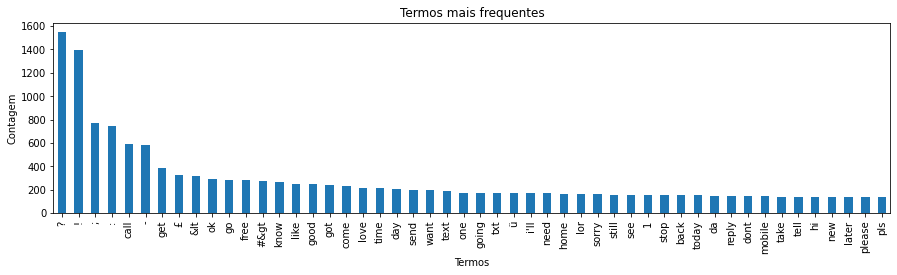

In [17]:
count_sms_limpo = pd.DataFrame.from_dict(Counter(sms_limpo).most_common(50))
count_sms_limpo.plot(kind = 'bar', legend = False, figsize = (15, 3.5))
plt.xticks(np.arange(50), count_sms_limpo[0])
plt.title('Termos mais frequentes')
plt.xlabel('Termos')
plt.ylabel('Contagem')
plt.show()


In [18]:
sms['text_trat']=1

In [19]:
for i in range(0,len(sms),1):
    a= sms['text'][i].lower().replace('.', ' ').replace(',', ' ').replace('?', ' ? ').replace('!', ' ! ').replace('\\', ' \\ ').replace(':', ' : ').replace(';', ' ; ').replace('-', ' - ').replace('_', ' _ ').replace('@', ' @ ').replace('(', ' ').replace(')', ' ').replace('$', ' $ ').replace('£', ' £ ').split()
    sms['text_trat'][i] = listToString([sla for sla in a if sla not in final_stopword_list])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [20]:
sms

,class,text,text_trat
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried contact £ 750 pound prize claim...
5568,ham,Will ü b going to esplanade fr home?,ü going esplanade fr home ?
5569,ham,"Pity, * was in mood for that. So...any other s...",pity * mood suggestions ?
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like i'd interested buying ...


In [41]:
drive.mount('/drive')
sms.to_csv('/drive/My Drive/Colab_Github/Colab_Github/sms.csv',index=True)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [21]:
sms_trat= sms[['class','text_trat']]
sms_trat.columns = ['class', 'text']

Matriz esparsa para economizar memória!

Atributo  𝑗  (coluna) na linha  𝑖  é igual à quantidade de vezes que a palavra associada ao índice  𝑗  aparece na SMS de índice  𝑖 .


In [22]:
X = feat_ext.fit_transform(sms_trat['text'])
print(np.shape(X))
# Dicotomizar as classes
sms['class'] = sms['class'].map({'spam':1,'ham':0})

(5572, 8431)


Então temos nesta matriz 8431 palavras e 5572 SMSs

Separando os dados em treinamento e teste:


In [23]:
X_train, X_test, y_train, y_test, idx_train, idx_test = model_selection.train_test_split(
    X, sms['class'], sms.index, test_size = 0.33,random_state= 42)

print([np.shape(X_train), np.shape(X_test)])

[(3733, 8431), (1839, 8431)]


Para balancear os dados de treinamento, utilizaremos undersampling, foi adotada a porcentagem relativa, para que sejam descartados menos dados da classe majoritária.


In [24]:
# sampling_strategy é o argumento que indica a porcentagem relativa da classe minoritária.

undersample = RandomUnderSampler(random_state=200, sampling_strategy=0.25)
X_train_US, y_train_US = undersample.fit_resample(X_train, y_train)
X_train_US.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(2505, 8431)

In [25]:
X_train.shape

(3733, 8431)

In [26]:
y_train.shape

(3733,)

# Modelagem Multinomial Naive Bayes


 * Consideramos a independência condicional entre os atributos, isto é a ocorrência das palavras não se influenciam.
 
 * Multinomial Naïve Bayes considera um vetor de característica onde um determinado termo representa o número de vezes que aparece, isto é, a frequência.

## Undersampling para trinamento do modelo

In [27]:
Classificador_US = MultinomialNB()


lista_parametros = {'alpha': [ i+0.1 for i in arange(0.0,2.0,0.1)]}

rand_search = RandomizedSearchCV(Classificador_US, 
                                 param_distributions = lista_parametros,
                                 cv = 10,
                                 random_state = 42,
                                 scoring = 'f1') 
rand_search.fit(X_train_US,y_train_US) 
Classificador_US = rand_search.best_estimator_

# Modelagem Complement Naive Bayes

 * Consideramos a independência condicional entre os atributos, isto é a ocorrência das palavras não se influenciam.
 
 * CNB é uma adaptação do Multinomial Naive Bayes, sendo que é particularmente adequado para conjuntos de dados desbalanceados.

In [28]:
Classificador2 = ComplementNB().fit(X_train,y_train)


Classificador_ComplementNB = ComplementNB()


lista_parametros = {'alpha': [ i+0.1 for i in arange(0.0,2.0,0.1)]}

rand_search = RandomizedSearchCV(Classificador_ComplementNB, 
                                 param_distributions = lista_parametros,
                                 cv = 10,
                                 random_state = 42,
                                 scoring = 'f1') 
rand_search.fit(X_train,y_train) 

Classificador_ComplementNB = rand_search.best_estimator_


# SVM

In [29]:
classificador_SVM = SVC(probability = True, random_state = 42)

lista_parametros = {"C": [ i+0.1 for i in arange(0,10.0,0.5)],
             "gamma":[i + 1 for i in range(0,10,1)],
             "kernel": ["linear", "poly", "rbf", "sigmoid"]
       }
              
rand_search = RandomizedSearchCV(classificador_SVM, 
                                 param_distributions = lista_parametros,
                                 cv = 10,
                                 random_state = 42,
                                 scoring = 'f1') 
rand_search.fit(X_train,y_train) 

classificador_SVM = rand_search.best_estimator_


# 10-Fold Cross Validation

In [30]:
scoring = ['accuracy','f1','precision', 'recall']
scores_Classificador_US = cross_validate(Classificador_US,X_train_US,y_train_US, scoring=scoring)
scores_Classificador_ComplementNB = cross_validate(Classificador_ComplementNB,X_train,y_train, scoring=scoring)
scores_classificador_SVM = cross_validate(classificador_SVM,X_train,y_train, scoring=scoring)
#sorted(scores.keys())
#scores
## 10-fold explícito

In [31]:
scores_Classificador_US

{'fit_time': array([0.00390601, 0.00303936, 0.00337648, 0.00339866, 0.00254464]),
 'score_time': array([0.00544333, 0.00464177, 0.0040288 , 0.00339532, 0.00275135]),
 'test_accuracy': array([0.97005988, 0.98203593, 0.96806387, 0.98403194, 0.97804391]),
 'test_f1': array([0.92307692, 0.95477387, 0.91919192, 0.95876289, 0.94527363]),
 'test_precision': array([0.94736842, 0.95959596, 0.92857143, 0.9893617 , 0.95      ]),
 'test_recall': array([0.9       , 0.95      , 0.91      , 0.93      , 0.94059406])}

In [32]:
  Resultados=PrettyTable()
  Resultados.field_names=["Média da métrica","MultinomialNB","ComplementNB","SVM"]
  Resultados.title= 'Tabela 10-Fold'
  Resultados.align["Média da métrica"]="l"
  Resultados.align["ComplementNB"]="c"
  Resultados.align["MultinomialNB"]="c"
  Resultados.align["SVM"]="c"

  Resultados.add_row(["Acurácia:",scores_Classificador_US['test_accuracy'].mean().round(2),scores_Classificador_ComplementNB['test_accuracy'].mean().round(2),scores_classificador_SVM['test_accuracy'].mean().round(2)])
  Resultados.add_row(["Precisão:",scores_Classificador_US['test_precision'].mean().round(2),scores_Classificador_ComplementNB['test_precision'].mean().round(2),scores_classificador_SVM['test_precision'].mean().round(2)])
  Resultados.add_row(["Recall:",scores_Classificador_US['test_recall'].mean().round(2),scores_Classificador_ComplementNB['test_recall'].mean().round(2),scores_classificador_SVM['test_recall'].mean().round(2)])
  Resultados.add_row(["F1-Score:",scores_Classificador_US['test_f1'].mean().round(2),scores_Classificador_ComplementNB['test_f1'].mean().round(2),scores_classificador_SVM['test_f1'].mean().round(2)])

  print(Resultados)

+--------------------------------------------------------+
|                     Tabela 10-Fold                     |
+------------------+---------------+--------------+------+
| Média da métrica | MultinomialNB | ComplementNB | SVM  |
+------------------+---------------+--------------+------+
| Acurácia:        |      0.98     |     0.94     | 0.98 |
| Precisão:        |      0.95     |     0.71     | 0.98 |
| Recall:          |      0.93     |     0.97     | 0.85 |
| F1-Score:        |      0.94     |     0.82     | 0.91 |
+------------------+---------------+--------------+------+


# Validação teste

+-----------------------+
|     MultinomialNB     |
+-----------+-----------+
| Métrica   | Resultado |
+-----------+-----------+
| Acurácia: |      0.98 |
| Precisão: |      0.91 |
| Recall:   |      0.95 |
| F1-Score: |      0.93 |
+-----------+-----------+


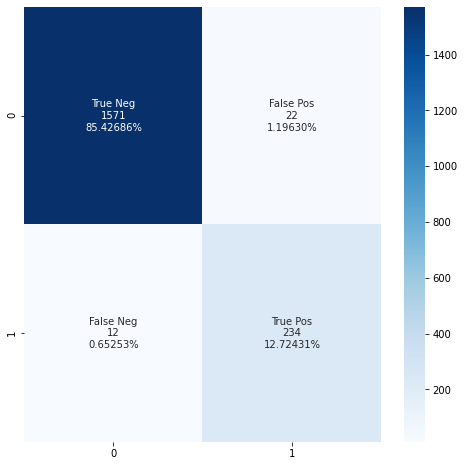

In [33]:
matriz_confusao(y_test,Classificador_US.predict(X_test),'MultinomialNB')


+-----------------------+
|      ComplementNB     |
+-----------+-----------+
| Métrica   | Resultado |
+-----------+-----------+
| Acurácia: |      0.95 |
| Precisão: |      0.73 |
| Recall:   |      0.96 |
| F1-Score: |      0.83 |
+-----------+-----------+


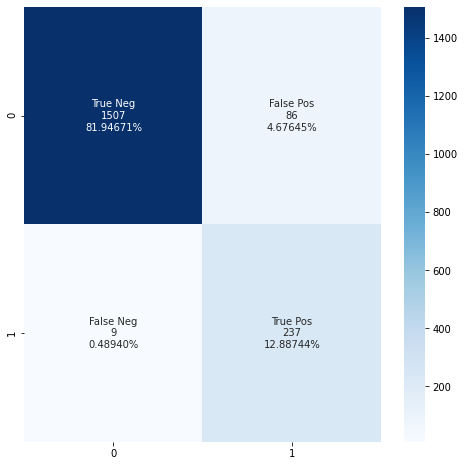

In [34]:
matriz_confusao(y_test,Classificador_ComplementNB.predict(X_test),'ComplementNB')


+-----------------------+
|          SVM          |
+-----------+-----------+
| Métrica   | Resultado |
+-----------+-----------+
| Acurácia: |      0.99 |
| Precisão: |       1.0 |
| Recall:   |       0.9 |
| F1-Score: |      0.95 |
+-----------+-----------+


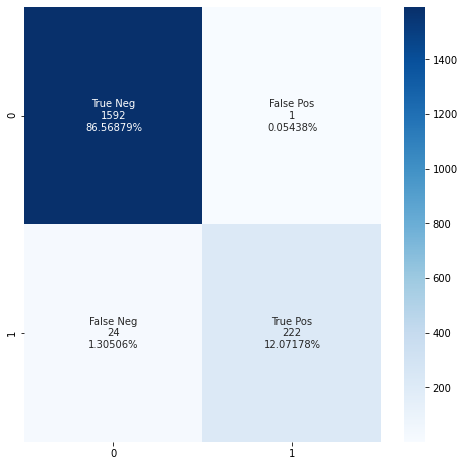

In [35]:
matriz_confusao(y_test,classificador_SVM.predict(X_test),'SVM')